<a href="https://colab.research.google.com/github/ymuto0302/base2_2020/blob/master/opendata3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# オープンデータの活用(3)
東京都，神奈川県，北海道，大阪府等，多くの自治体が新型コロナウイルス(COVID-19)に関するデータをオープンデータとして公開している。

### 各自治体の提供するデータの形式
CSV形式であるが，項目名や文字コード(encoding)は様々である。
例えば東京都は utf-8，北海道は Shift JIS を文字コードとして用いる。

### 目標：北海道の提供するデータを用いて，ヒートマップを作る
北海道は「北海道オープンデータカタログサイト」
https://www.harp.lg.jp/opendata/dataset/
にてデータを提供している。

このサイトにおいて，新型コロナウイルス感染症に関するデータは
https://www.harp.lg.jp/opendata/dataset/1369.html
に置かれている。この中から「陽性患者属性」をまとめた "patients.csv" を用いる。


```
No,リリース日,曜日,居住地,年代,性別,属性,備考,補足,退院,周囲の状況,濃厚接触者の状況,age_group,sex_en
1,2020-01-28T00:00,,中国武漢市,40代,女性,−,−,,,なし,濃厚接触者を特定し、健康観察終了,40,woman
2,2020-02-14T00:00,,札幌市,50代,男性,自営業,−,,,札幌市公表中,札幌市公表中,50,man
3,2020-02-19T00:00,,札幌市,40代,男性,会社員,−,,,札幌市公表中,札幌市公表中,40,man
4,2020-02-19T00:00,,七飯町,60代,男性,町議会議員,−,,,No.12,濃厚接触者を特定し、健康観察終了,60,man
5,2020-02-19T00:00,,札幌市,40代,男性,会社員,−,,,札幌市公表中,札幌市公表中,40,man
6,2020-02-21T00:00,,中富良野町,10歳未満,男性,小学生,−,,,No.7,濃厚接触者を特定し、健康観察終了,10,man
```

#### まずは Google Drive のマウント

In [1]:
# Google Drive のマウント
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### 必要なライブラリのインポート
今回は pandas, datetime, matplotlib を用いる。datetime は日付データを取り扱うライブラリ，matplotib は可視化，特に今回はヒートマップを作成するために用いる。

In [39]:
import pandas as pd # データ解析ライブラリ
import datetime as dt # 日付データを取り扱うライブラリ
import matplotlib.pyplot as plt # 可視化ライブラリ
import numpy as np # 数値解析ライブラリ (可視化の際に少しだけ使う)

#### データの読み込み

In [26]:
# CSV ファイルからデータ読み込み
# (注意) 北海度の提供するデータは Shift JIS で書かれているが，Pythonで処理する場合，
# (encoding="shift_jis" でなく) encoding="cp932"で指定しないとうまくいかないようだ。
df = pd.read_csv("/content/drive/My Drive/BASE2/OpenData/hokkaido_covid19_patients.csv", encoding="cp932")

In [27]:
df

,No,リリース日,曜日,居住地,年代,性別,属性,備考,補足,退院,周囲の状況,濃厚接触者の状況,age_group,sex_en
0,1,2020-01-28T00:00,NaN,中国武漢市,40代,女性,－,－,NaN,NaN,なし,濃厚接触者を特定し、健康観察終了,40,woman
1,2,2020-02-14T00:00,NaN,札幌市,50代,男性,自営業,－,NaN,NaN,札幌市公表中,札幌市公表中,50,man
2,3,2020-02-19T00:00,NaN,札幌市,40代,男性,会社員,－,NaN,NaN,札幌市公表中,札幌市公表中,40,man
3,4,2020-02-19T00:00,NaN,七飯町,60代,男性,町議会議員,－,NaN,NaN,No.12,濃厚接触者を特定し、健康観察終了,60,man
4,5,2020-02-19T00:00,NaN,札幌市,40代,男性,会社員,－,NaN,NaN,札幌市公表中,札幌市公表中,40,man
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,1113,2020-06-06T00:00,NaN,札幌市,非公表,非公表,無職,軽症 会話可,NaN,NaN,札幌市公表中,札幌市公表中,0,-
1113,1114,2020-06-06T00:00,NaN,札幌市,60代,女性,自営業,軽症 会話可,NaN,NaN,札幌市公表中,札幌市公表中,60,woman
1114,1115,2020-06-06T00:00,NaN,札幌市,60代,非公表,非公表,軽症 会話可,NaN,NaN,札幌市公表中,札幌市公表中,60,-
1115,1116,2020-06-06T00:00,NaN,札幌市,70代,男性,無職,軽症 会話可,NaN,NaN,札幌市公表中,札幌市公表中,70,man


In [28]:
# リリース日（＝公表日），居住地，年代，性別のみを取り出す
df = df.loc[:, ["リリース日", "居住地", "年代", "性別"]]

#### リリース日を用いたデータ抽出
COVID-19 患者データの収集は2020年1月頃から始まっており，過去のデータを全て取り上げるのは適切でない。そこで「リリース日」を基に，直近のデータのみを取り出す。

ここで月日による選別を行うため，「リリース日」を予め datetime 型に変換する必要がある。

さらに，後ほどデータ結合(conatenate)を行うため，データ抽出後に str 型(文字列型)へ戻す。

In [29]:
# あまり昔のデータを使いたくないから，日付によるデータ抽出を行う
# そのため，「リリース日」を datetime 型に型変換する
df['リリース日'] = pd.to_datetime(df['リリース日'])

# 5月15日以降のデータのみ抽出する
df = df[df["リリース日"] > dt.datetime(2020, 5, 15)].reset_index()

# 後々，データの結合が必要なため，「リリース日」を str 型へ戻す
df['リリース日'] = df['リリース日'].astype(str)

In [30]:
df

,index,リリース日,居住地,年代,性別
0,999,2020-05-16,札幌市,60代,男性
1,1000,2020-05-16,札幌市,70代,女性
2,1001,2020-05-16,非公表,非公表,非公表
3,1002,2020-05-16,札幌市,40代,女性
4,1003,2020-05-16,札幌市,70代,女性
...,...,...,...,...,...
113,1112,2020-06-06,札幌市,非公表,非公表
114,1113,2020-06-06,札幌市,60代,女性
115,1114,2020-06-06,札幌市,60代,非公表
116,1115,2020-06-06,札幌市,70代,男性


In [31]:
# リリース日および年代でグループ化して，"患者数[6月1日, 40代]=3人" のような構造を作る
df["カウント"] = 1 # 可視化の際に利用するため，個々の患者に 1 を割り振る

# 行と列を指定してピボット（再形成）
# ここでは「年代」を列としてデータを並べ替えている
df_pivot = df.pivot(columns="年代", values="カウント")

# 元データの「リリース日」と pivot により並べ替えたデータを結合する
df = pd.concat([df["リリース日"], df_pivot], axis=1)

In [32]:
df

,リリース日,10代,10歳未満,20代,30代,40代,50代,60代,70代,80代,90代,非公表
0,2020-05-16,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1,2020-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2,2020-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,2020-05-16,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
113,2020-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
114,2020-06-06,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
115,2020-06-06,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
116,2020-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


#### NaN の部分をゼロで埋める

In [33]:
# 値のない箇所をゼロで埋める
df = df.fillna(0)

In [34]:
df

,リリース日,10代,10歳未満,20代,30代,40代,50代,60代,70代,80代,90代,非公表
0,2020-05-16,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2020-05-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2020-05-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2020-05-16,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-05-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
113,2020-06-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
114,2020-06-06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
115,2020-06-06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
116,2020-06-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### データを強引に並べ替える
上記のデータフレームを眺めて分かるように，「10歳未満」と「10代」の順序が不適当である。また「非公表」の列は不要である。

そこで，強引にデータを並べ替える。

In [35]:
# ヒートマップ作成へ向けて，データの(強制的な)並べ替え
df = df[["リリース日", "10歳未満", "10代", "20代", "30代", "40代", "50代", "60代", "70代", "80代"]]

In [21]:
df

,リリース日,10歳未満,10代,20代,30代,40代,50代,60代,70代,80代
0,2020-05-16,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2020-05-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2020-05-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-05-16,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2020-05-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
113,2020-06-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,2020-06-06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
115,2020-06-06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
116,2020-06-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### リリース日でグループ化し，各日の患者数の合計を求める

In [36]:
# 「リリース日」でグループ化し，各日の合計を求める
df = df.groupby("リリース日").sum()

In [37]:
df

,10歳未満,10代,20代,30代,40代,50代,60代,70代,80代
リリース日,,,,,,,,,
2020-05-16,0.0,0.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0
2020-05-17,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0
2020-05-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-19,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
2020-05-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2020-05-21,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0
2020-05-22,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0
2020-05-23,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0
2020-05-24,0.0,0.0,0.0,1.0,2.0,2.0,0.0,6.0,1.0


#### ヒートマップを用いた可視化
ヒートマップとは値に応じて色を付与することで，値の大小を直観的に把握する手法である。

以下にプログラム例を示す。

また，matplotlib で利用可能なヒートマップの一覧が下記に示されているから，適宜，参照して欲しい。

https://matplotlib.org/examples/color/colormaps_reference.html

                A         B         C         D
alpha    1.039433  1.155931  1.030319  1.109128
beta     1.893748  1.112915  0.725616  1.407374
gamma    0.740389  0.619978  2.263047  0.479866
delta    0.368806  1.714921  0.083223  0.385295
epsilon  0.374349  0.406886  0.730679  0.679631


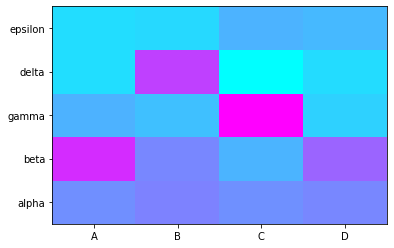

In [25]:
import numpy as np 
from pandas import DataFrame
import matplotlib.pyplot as plt

# データフレームを作る（値は適当な乱数）
Index= ['alpha', 'beta', 'gamma', 'delta', 'epsilon']
Cols = ['A', 'B', 'C', 'D']
sample_df = DataFrame(abs(np.random.randn(5, 4)), index=Index, columns=Cols)

# データフレームの表示
print(sample_df)

# ヒートマップの作成・表示
plt.pcolor(sample_df, cmap="cool")
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

#### COVID-19 データの可視化
北海道の COVID-19 患者の年代別・月日別ヒートマップを作成する。

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27507 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26410 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20195 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27507 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26410 missing from current font.
  font.set_te

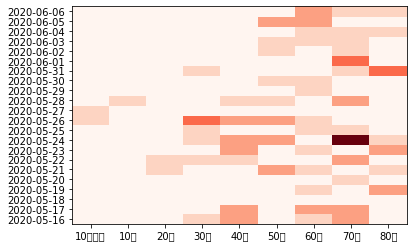

In [38]:
# 可視化：ヒートマップの生成
plt.pcolor(df, cmap="Reds")
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

            10歳未満  10代  20代  30代  40代  50代  60代  70代  80代
リリース日                                                    
2020-05-16    0.0  0.0  0.0  1.0  2.0  0.0  1.0  2.0  0.0
2020-05-17    0.0  0.0  0.0  0.0  2.0  0.0  2.0  2.0  0.0
2020-05-18    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2020-05-19    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  2.0
2020-05-20    0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
2020-05-21    0.0  0.0  1.0  0.0  0.0  2.0  1.0  0.0  1.0
2020-05-22    0.0  0.0  1.0  1.0  1.0  0.0  0.0  2.0  0.0
2020-05-23    0.0  0.0  0.0  0.0  2.0  0.0  1.0  0.0  2.0
2020-05-24    0.0  0.0  0.0  1.0  2.0  2.0  0.0  6.0  1.0
2020-05-25    0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0
2020-05-26    1.0  0.0  0.0  3.0  2.0  2.0  1.0  0.0  0.0
2020-05-27    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2020-05-28    0.0  1.0  0.0  0.0  1.0  1.0  0.0  2.0  0.0
2020-05-29    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
2020-05-30    0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
2020-05-31    

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27507 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26410 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20195 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27507 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26410 missing from current font.
  font.set_te

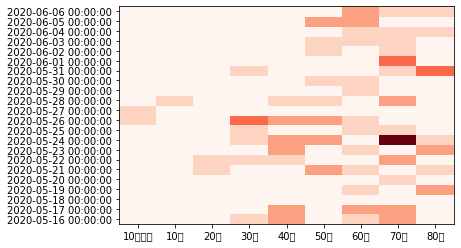

In [40]:
'''
新型コロナウイルス感染症に関するデータ【北海道】の利用
'''
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

# CSV ファイルからデータ読み込み
# (注意) 北海度の提供するデータは Shift JIS で書かれているが，Pythonで処理する場合，
# (encoding="shift_jis" でなく) encoding="cp932"で指定しないとうまくいかないようだ。
df = pd.read_csv("/content/drive/My Drive/BASE2/OpenData/hokkaido_covid19_patients.csv", encoding="cp932")

# リリース日（＝公表日），居住地，年代，性別のみを取り出す
df = df.loc[:, ["リリース日", "居住地", "年代", "性別"]]

# あまり昔のデータを使いたくないから，日付によるデータ抽出を行う
# そのため，「リリース日」を datetime 型に型変換する
df['リリース日'] = pd.to_datetime(df['リリース日'])

# 5月15日以降のデータのみ抽出する
df = df[df["リリース日"] > dt.datetime(2020, 5, 15)].reset_index()

# 後々，データの結合が必要なため，「リリース日」を str 型へ戻す
#df['リリース日'] = df['リリース日'].astype(str)

# リリース日および年代でグループ化して，"患者数[6月1日, 40代]=3人" のような構造を作る
df["カウント"] = 1 # 可視化の際に利用するため，個々の患者に 1 を割り振る

# 行と列を指定してピボット（再形成）
# ここでは「年代」を列としてデータを並べ替えている
df_pivot = df.pivot(columns="年代", values="カウント")

# 元データの「リリース日」と pivot により並べ替えたデータを結合する
df = pd.concat([df["リリース日"], df_pivot], axis=1)

# 値のない箇所をゼロで埋める
df = df.fillna(0)

# データの(強制的な)並べ替え
df = df[["リリース日", "10歳未満", "10代", "20代", "30代", "40代", "50代", "60代", "70代", "80代"]]

# 「リリース日」でグループ化し，各日の合計を求める
df = df.groupby("リリース日").sum()

print(df)

# 可視化：ヒートマップの生成
import matplotlib.pyplot as plt
import numpy as np
plt.pcolor(df, cmap="Reds")
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()
# plt.savefig("heatmap.png")